In [18]:
import datacube
dc = datacube.Datacube()

# dss = dc.find_datasets(product='s2a_ard_granule', id='e3e5d705-9f37-5016-9c9f-4df89c7e80d1')

ds = dc.load(product=['s2a_ard_granule', 's2b_ard_granule'], 
#              time='2022-10-07',
             time='2022',
             x=(135.23114186, 136.21160176),
             y=( -14.24143994, -15.27481845),
             measurements=['nbart_red', 'nbart_green', 'nbart_blue', 'solar_zenith', 'solar_azimuth', 'satellite_azimuth', 'satellite_view', 'relative_azimuth'], 
             output_crs='EPSG:3577', 
             group_by='solar_day',
             resolution=(-200, 200))

ds = ds.where(ds.nbart_red > 0)

# ds[['nbart_red', 'nbart_green', 'nbart_blue']].squeeze('time').to_array().plot.imshow(vmin=0, vmax=2000)

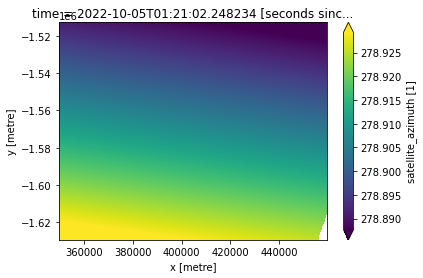

In [5]:
ds.satellite_azimuth.plot(robust=True)

In [22]:
import numpy as np
import matplotlib.pyplot as plt


def glint_angle(solar_azimuth, solar_zenith, view_azimuth, view_zenith):
    """
    Calculates glint angles for each pixel in a satellite
    image based on the relationship between the solar and
    sensor zenith and azimuth viewing angles at the moment
    the image was acquired.

    Glint angle is considered a predictor of sunglint over
    water; small glint angles (e.g. < 20 degrees) are associated
    with a high probability of sunglint due to the viewing
    angle of the sensor being aligned with the specular
    reflectance of the sun from the water's surface.

    Based on code from https://towardsdatascience.com/how-to-implement-
    sunglint-detection-for-sentinel-2-images-in-python-using-metadata-
    info-155e683d50
    """

    # Convert angle arrays to radians
    solar_zenith_rad = np.deg2rad(solar_zenith)
    solar_azimuth_rad = np.deg2rad(solar_azimuth)
    view_zenith_rad = np.deg2rad(view_zenith)
    view_azimuth_rad = np.deg2rad(view_azimuth)

    # Calculate sunglint angle
    phi = sun_azimuth_rad - view_azimuth_rad
    glint_angle = np.cos(view_zenith_rad) * np.cos(solar_zenith_rad) - np.sin(
        view_zenith_rad
    ) * np.sin(solar_zenith_rad) * np.cos(phi)

    # Convert to degrees
    glint_array = np.degrees(np.arccos(glint_angle))

    return glint_array


glint_array = sunglint_angle(
    solar_azimuth=ds.solar_azimuth,
    solar_zenith=ds.solar_zenith,
    view_azimuth=ds.satellite_azimuth,
    view_zenith=ds.satellite_view,
)

glint_array.plot(cmap="magma_r", vmin=15, vmax=30, col='time', col_wrap=)

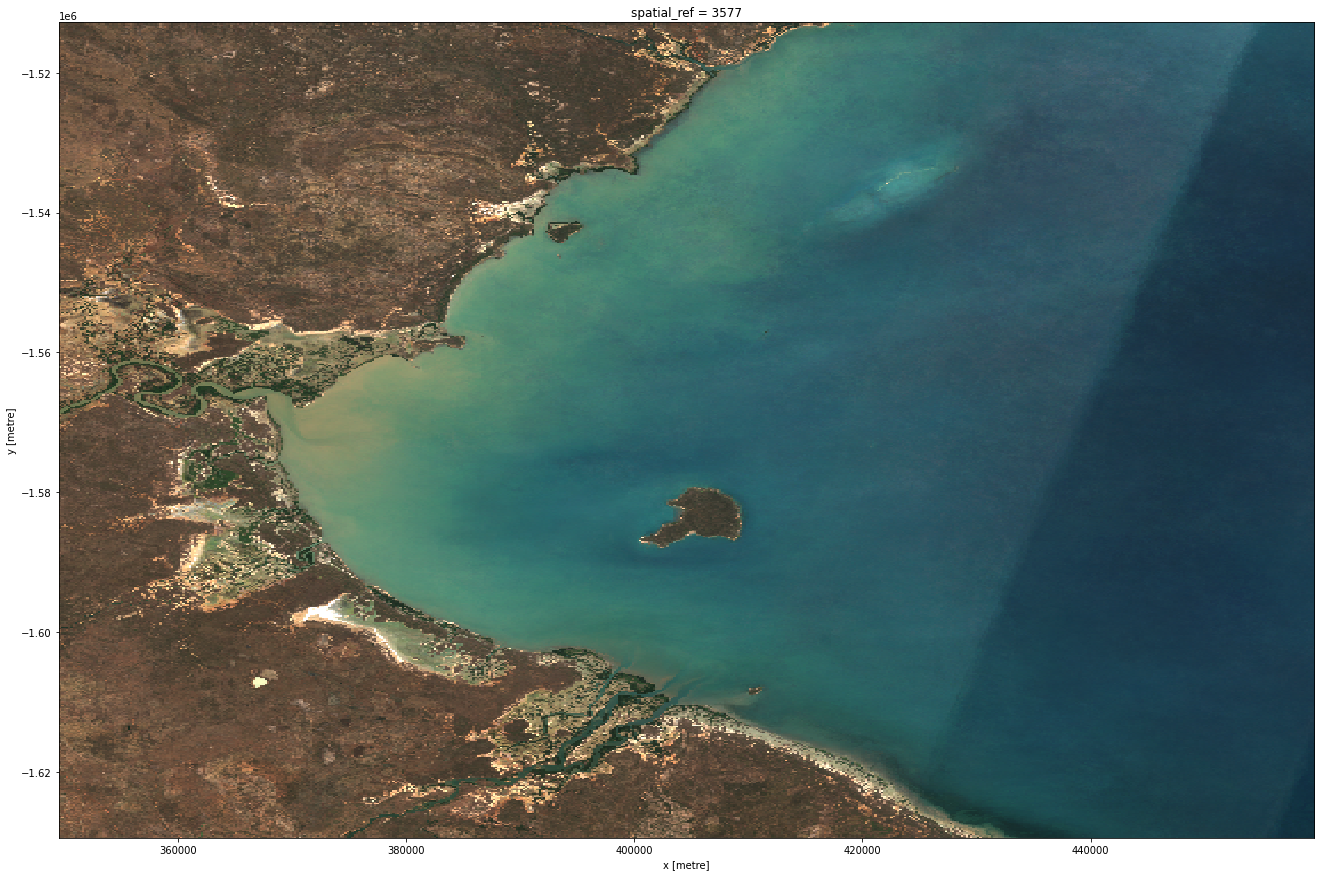

In [27]:
ds[['nbart_red', 'nbart_green', 'nbart_blue']].median('time').to_array().plot.imshow(vmin=0, vmax=2500, size=15)

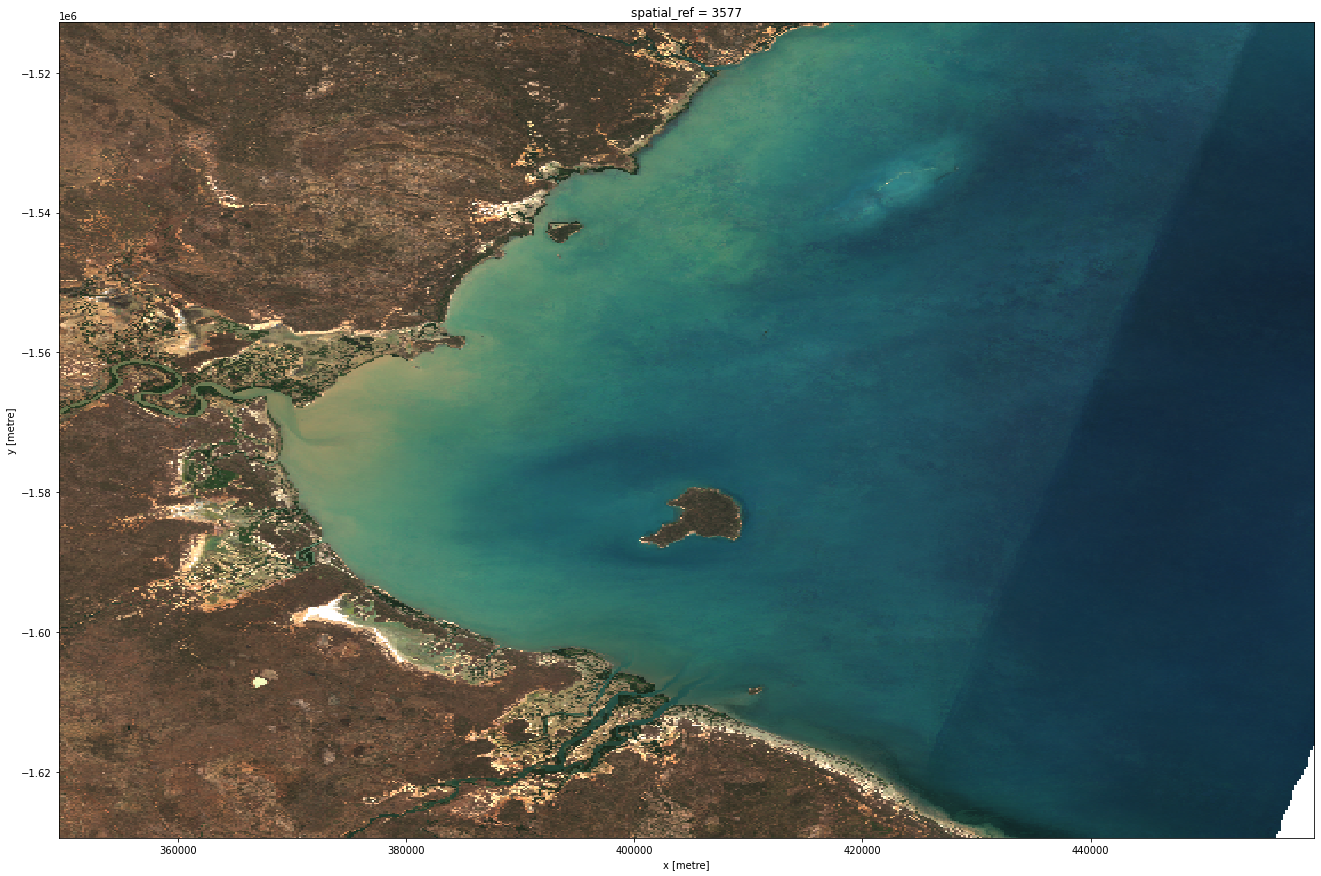

In [28]:

ds[['nbart_red', 'nbart_green', 'nbart_blue']].where(glint_array > 25).median('time').to_array().plot.imshow(vmin=0, vmax=2500, size=15)

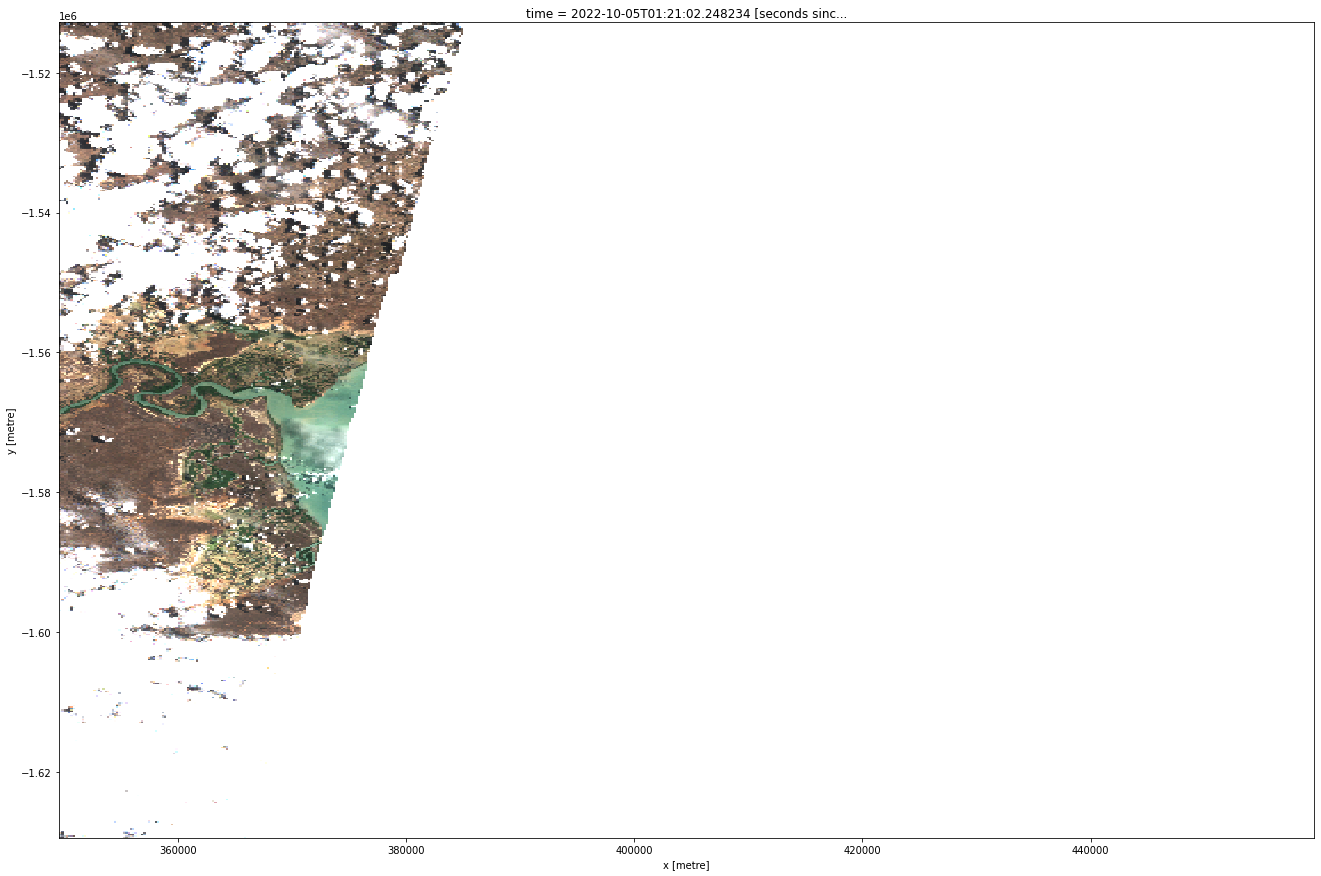

In [7]:
ds[['nbart_red', 'nbart_green', 'nbart_blue']].squeeze('time').to_array().where(glint_array > 20).plot.imshow(vmin=0, vmax=2500, size=15)

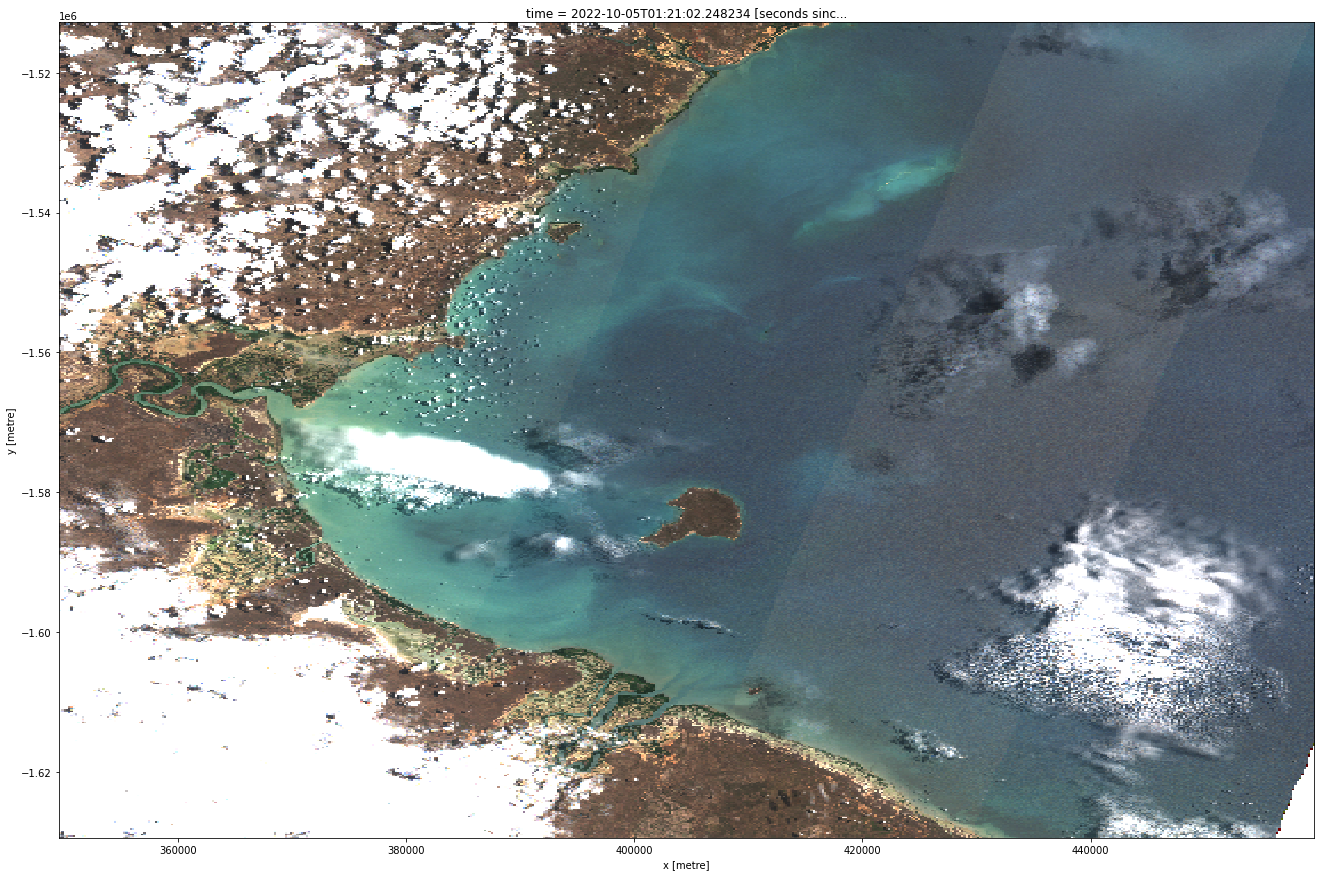

In [8]:
ds[['nbart_red', 'nbart_green', 'nbart_blue']].squeeze('time').to_array().plot.imshow(vmin=0, vmax=2500, size=15)

<AxesSubplot:xlabel='datetime'>

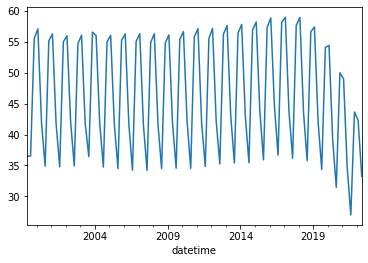

In [225]:
metadata_df.set_index('datetime').resample('3M').mean()['eo:sun_elevation'].plot()